In [88]:
from self_supervised_halos.utils.utils import data_preprocess_path, check_cuda
from scripts.halo_mass_embeddings import mask_time_series_batch, transformer_model

from self_supervised_halos.utils.dataloader import HaloDataset, img2d_transform, subhalos_df, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

device = check_cuda()

CUDA is not available.
Device: cpu


In [74]:
dataset = HaloDataset(root_dir=data_preprocess_path,subhalos_df=subhalos_df, 
                      load_2d=False, load_3d=False, load_mass=True,)

Preparing mass data: 100%|██████████| 16544/16544 [00:17<00:00, 921.62it/s] 


In [75]:
if device=='cpu':
    batch_size = 128
else:
    print('dataloader on gpu')
    batch_size = 512

print(f'Batch size: {batch_size}')

n_data = len(dataset)
f_train = 0.6
f_val = 0.2
f_test = 1 - f_train - f_val


train_size = int(f_train*len(dataset))
val_size = int(f_val*len(dataset))
test_size = len(dataset) - train_size - val_size


trainval_ds, test_ds = torch.utils.data.random_split(dataset, [train_size+val_size, test_size])
train_size = int(f_train/(f_train+f_val)*len(trainval_ds))
val_size = len(trainval_ds) - train_size

train_ds, val_ds = torch.utils.data.random_split(trainval_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)


Batch size: 128


In [76]:
for item in test_loader:
    break

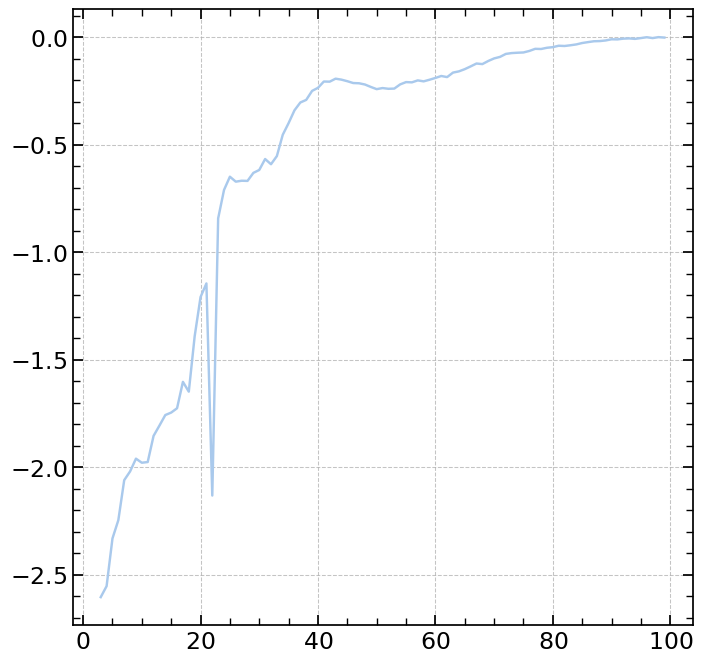

In [77]:
%matplotlib inline
plt.plot(item[0][2][33])
plt.show()

In [79]:

# Example usage
batch = item[0][2]

unmasked_signal, masked_signal, prediction_mask = mask_time_series_batch(batch)

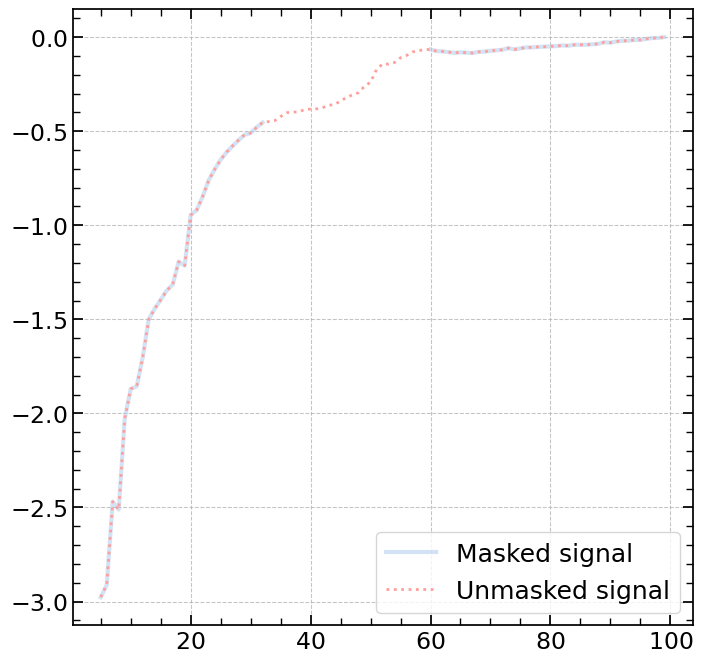

In [87]:
plt.plot(masked_signal[1], label='Masked signal', lw = 3, alpha = 0.5)
plt.plot(unmasked_signal[1], 'r:', lw = 2, label='Unmasked signal')
#plt.plot(unmasked_signal[1][prediction_mask[1]], 'g--', lw = 2, label='Unmasked signal to predict')
plt.legend()

In [204]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeSeriesTransformer(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, output_dim, dim_feedforward = 32):
        super(TimeSeriesTransformer, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=embed_dim, kernel_size=1)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout = 0.1,
                                                   batch_first = False)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc_out = nn.Linear(embed_dim, output_dim)

    def forward(self, x, src_key_padding_mask=None):
        # x shape: (batch_size, seq_len)
        x = x.unsqueeze(1)  # add channel dimension: (batch_size, 1, seq_len)
        x = self.conv1d(x)  # apply Conv1d: (batch_size, embed_dim, seq_len)
        x = x.permute(2, 0, 1)  # (seq_len, batch_size, embed_dim)
        x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)
        x = x.permute(1, 0, 2)  # (batch_size, seq_len, embed_dim)
        x = self.fc_out(x)  # (batch_size, seq_len, output_dim)
        return x

# Define model hyperparameters
embed_dim = 32  # Embedding dimension
num_heads = 4  # Number of attention heads
num_layers = 5  # Number of transformer layers
output_dim = 1  # Output dimension (for predicting the missing value)
dim_feedforward = 64  # Feedforward dimension

# Create the model
model = TimeSeriesTransformer(embed_dim , num_heads , num_layers , output_dim, dim_feedforward )
criterion = nn.MSELoss()

# Example usage
for item in test_loader:
    break
batch = item[0][2]

batch = batch.to(device)
batch = batch.float()
model = model.to(device)

# Mask some subsequences in the batch
unmasked_signal, masked_signal, prediction_mask = mask_time_series_batch(batch)

# Replace NaNs with zeros for processing
masked_signal_filled = torch.nan_to_num(masked_signal, nan=0.0)

# Create a src_key_padding_mask for the transformer
src_key_padding_mask = torch.isnan(masked_signal)

# Forward pass
predictions = model(masked_signal_filled, src_key_padding_mask=src_key_padding_mask)
predictions = predictions.squeeze(-1)  # Remove the last dimension

loss = criterion(predictions[prediction_mask], unmasked_signal[prediction_mask])


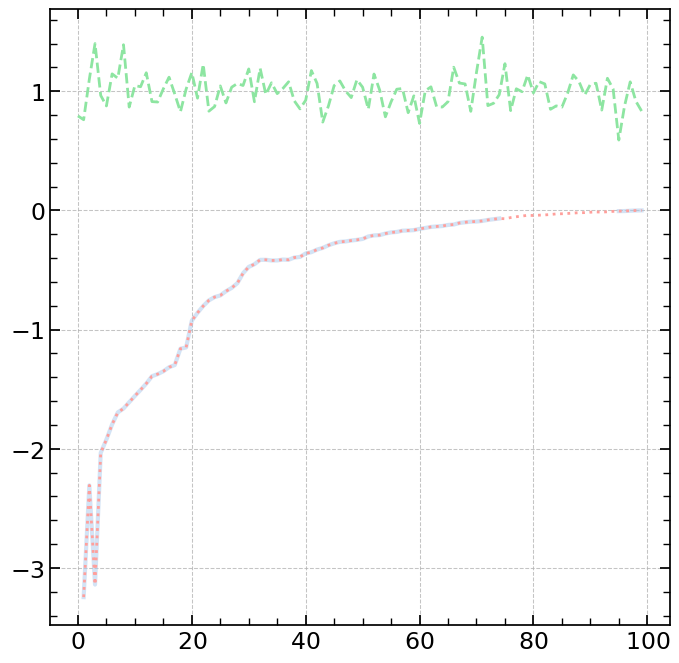

In [205]:
plt.plot(masked_signal[1], label='Masked signal', lw = 3, alpha = 0.5)
plt.plot(unmasked_signal[1], 'r:', lw = 2, label='Unmasked signal')
plt.plot(predictions[1].detach().cpu().numpy(), 'g--', lw = 2, label='Predicted signal')

In [206]:
n_pars = sum(p.numel() for p in model.parameters())
print(f'Number of parameters: {n_pars}')

Number of parameters: 42817


In [209]:
from tqdm import tqdm
# Hyperparameters
num_epochs = 10
learning_rate = 1e-3

# Define model hyperparameters
embed_dim = 8  # Embedding dimension
num_heads = 2  # Number of attention heads
num_layers = 2  # Number of transformer layers
output_dim = 1  # Output dimension (for predicting the missing value)
dim_feedforward = 32  # Feedforward dimension

#model
model = TimeSeriesTransformer(embed_dim , num_heads , num_layers , output_dim, dim_feedforward )
criterion = nn.MSELoss()

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set model to training mode
    epoch_loss = 0

    for item in test_loader:
        batch = item[0][2].to(device).float()

        # Mask some subsequences in the batch
        unmasked_signal, masked_signal, prediction_mask = mask_time_series_batch(batch)

        # Replace NaNs with zeros for processing
        masked_signal_filled = torch.nan_to_num(masked_signal, nan=0.0)

        # Create a src_key_padding_mask for the transformer
        src_key_padding_mask = torch.isnan(masked_signal)

        # Forward pass
        predictions = model(masked_signal_filled, src_key_padding_mask=src_key_padding_mask)
        predictions = predictions.squeeze(-1)  # Remove the last dimension

        # Compute the loss only on the tokens that need to be predicted
        loss = criterion(predictions[prediction_mask], unmasked_signal[prediction_mask])

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

print("Training complete.")

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:30,  3.42s/it]

Epoch [1/10], Loss: 0.5412


 20%|██        | 2/10 [00:06<00:27,  3.44s/it]

Epoch [2/10], Loss: 0.3231


 30%|███       | 3/10 [00:10<00:25,  3.69s/it]

Epoch [3/10], Loss: 0.3273


 40%|████      | 4/10 [00:14<00:21,  3.56s/it]

Epoch [4/10], Loss: 0.3110


 50%|█████     | 5/10 [00:17<00:17,  3.56s/it]

Epoch [5/10], Loss: 0.3056


 60%|██████    | 6/10 [00:21<00:14,  3.65s/it]

Epoch [6/10], Loss: 0.3013


 70%|███████   | 7/10 [00:24<00:10,  3.50s/it]

Epoch [7/10], Loss: 0.2981


 80%|████████  | 8/10 [00:28<00:06,  3.45s/it]

Epoch [8/10], Loss: 0.3125


 90%|█████████ | 9/10 [00:31<00:03,  3.46s/it]

Epoch [9/10], Loss: 0.2912


100%|██████████| 10/10 [00:35<00:00,  3.51s/it]

Epoch [10/10], Loss: 0.2933
Training complete.


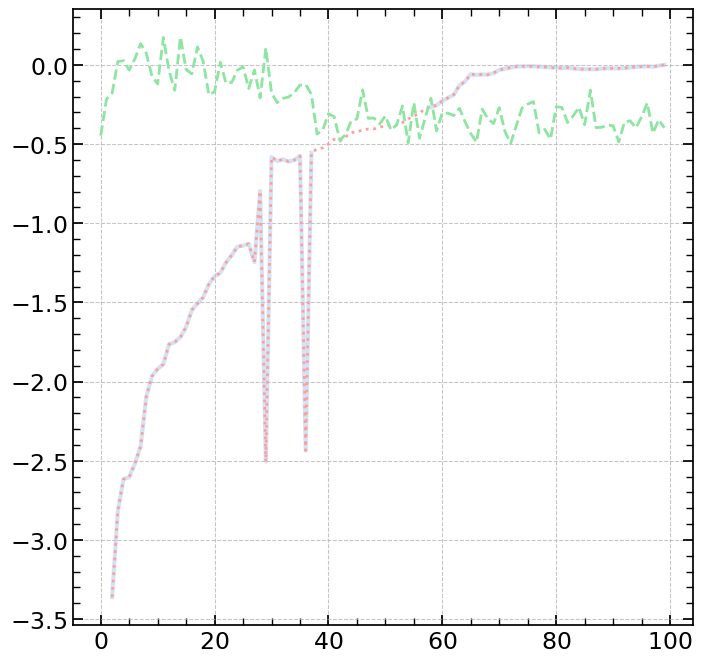

In [210]:
plt.plot(masked_signal[1], label='Masked signal', lw = 3, alpha = 0.5)
plt.plot(unmasked_signal[1], 'r:', lw = 2, label='Unmasked signal')
plt.plot(predictions[1].detach().cpu().numpy(), 'g--', lw = 2, label='Predicted signal')

In [215]:
model.transformer.layers[0]

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
  )
  (linear1): Linear(in_features=8, out_features=32, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=32, out_features=8, bias=True)
  (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)